# Персонализация предложений для клиентов «В один клик»  с целью увеличения покупательской активности.

#### Краткое описание:
Помочь фермеру приобрести бурёнок с оптимальными характеристиками для расширения стада коров. Для этого необходимо создать две прогнозные модели: одна для предсказания удоя коров, а другая для определения вероятности вкусного молока.

#### Цель проекта:
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

#### Описание данных:
Магазин предоставляет подробные данные о поведение пользователей на сайте и выручку от клиентов по периодам.

#### Краткий план:
- Загрузка данных:

Загрузка данных о пользователях в pandas.

Проверка соответствия данных описанию и стандартам оформления.

- Предобработка данных:

Проверка на пропуски и дубликаты.

Коррекция типов данных.

- Исследовательский анализ данных:

Статистический анализ признаков.

Построение графиков для количественных признаков.

- Корреляционный анализ признаков:

Расчет коэффициентов корреляции.

Построение матрицы корреляций количественных признаков.

- Обучение моделей:

Обучение четырех моделей.

Оценка качества моделей на тестовой выборке.

- Подбор параметров:

Выбор лучших параметров для каждой модели.

Расчет и анализ метрик

- Разработка предложения для выбранного сегмента

- Итоговые выводы




### Загрузка данных

In [1]:
!pip install -U scikit-learn
!pip install shap 

     |████████████████████████████████| 13.4 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 88.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import shap


In [3]:
# Загрузим датафреймы
data_market = pd.read_csv('/datasets/market_file.csv')
data_money = pd.read_csv('/datasets/market_money.csv')
data_time = pd.read_csv('/datasets/market_time.csv')
# Укажем разделитель в датафрейме ';' и заменим запятую на точку в разделители десятичной доли 
data_monthly_money = pd.read_csv('/datasets/money.csv', sep=';')
data_monthly_money['Прибыль'] = data_monthly_money['Прибыль'].str.replace(',', '.')
# Посмотрим данные
display(data_market.sample(5), data_money.sample(5), data_time.sample(5), data_monthly_money.sample(5))


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
914,216262,Прежний уровень,стандарт,да,5.3,4,253,0.27,Косметика и аксесуары,2,2,7,10
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
750,216098,Прежний уровень,стандарт,да,4.2,4,670,0.16,Мелкая бытовая техника и электроника,4,4,8,7
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
970,216318,Прежний уровень,премиум,да,3.9,5,1040,0.30,Косметика и аксесуары,2,3,5,14


,id,Период,Выручка
417,215487,препредыдущий_месяц,4923.0
2814,216286,текущий_месяц,4937.2
2993,216345,предыдущий_месяц,3887.5
1213,215752,препредыдущий_месяц,4635.0
1825,215956,текущий_месяц,5392.5


,id,Период,минут
2426,216561,текущий_месяц,7
2425,216560,предыдцщий_месяц,17
2394,216545,текущий_месяц,23
537,215616,текущий_месяц,8
2309,216502,текущий_месяц,9


,id,Прибыль
262,215610,4.61
513,215861,3.89
914,216262,4.62
955,216303,4.69
205,215553,3.01


Данные соответствуют описанию

### Шаг 2. Предобработка данных

In [4]:
data_market.info()
data_money.info()
data_time.info()
data_monthly_money.info()

pd.set_option('display.float_format', '{:.2f}'.format)

display(data_market.describe(), data_money.describe(), data_time.describe(), data_monthly_money.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


,id,Выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20


,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00


,id
count,1300.00
mean,215997.50
std,375.42
min,215348.00
25%,215672.75
50%,215997.50
75%,216322.25
max,216647.00


Некоторые типы данных не соответствуют самим данным. Также судя по разнице максимального значения и значения 75 квантиля data_money содержит выбросы. Далее более детально рассмотрим распределение data_money и удалим выбросы.

In [5]:
# Изменим типы данных
data_monthly_money['Прибыль'] = data_monthly_money['Прибыль'].astype(float)
data_time['минут'] = data_time['минут'].astype(int)

In [6]:
# Проверим наличие дубликатов
display(data_market.duplicated().sum(), data_money.duplicated().sum(), data_time.duplicated().sum(), data_monthly_money.duplicated().sum())
display(data_market.isna().sum(), data_money.isna().sum(), data_time.isna().sum(), data_monthly_money.isna().sum())

0

0

0

0

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64

Полных дубликатов и пропущенных значений нет

In [7]:
# Посмотрим есть ли неявные дубликаты среди значений в категориальных столбцах
display(data_market['Покупательская активность'].value_counts())
display(data_market['Тип сервиса'].value_counts())
display(data_market['Разрешить сообщать'].value_counts())
display(data_market['Популярная_категория'].value_counts()) 

display(data_money['Период'].value_counts()) 
display(data_time['Период'].value_counts()) 

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: Период, dtype: int64

текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

In [8]:
# Устраним дубликат 
data_market['Тип сервиса'] = data_market['Тип сервиса'].replace('стандартт', 'стандарт')
data_time['Период'] = data_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
# Выводим результат
display(data_market['Тип сервиса'].value_counts())
display(data_time['Период'].value_counts()) 

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

предыдущий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

### Шаг 3. Исследовательский анализ

In [9]:
# Отфильтруем пользователей у кого есть нули в выручке т.е. период без покупок
#filtered_data = data_money[data_money['Выручка'] == 0]
# Извлечем таких пользователей
#users_with_zero_revenue = filtered_data['id'].unique()
# Создадим отфильтрованый список из пользователей с активностью за последние 3 месяца
#filtered_data_money = data_money[data_money['Выручка'] != 0]
#print("Кол-во неактивных пользователей", users_with_zero_revenue, "Кол-во оставшихся строк",len(filtered_data_money))

Неплохой результат, всего 3 пользователя были неактивны за последние 3 месяца. Удалено всего 6 строк. 

In [10]:
# Распределим значения в data_money['Период'] по отдельным столбцам
pivot_data_money = data_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='first').reset_index()
# Добавляем "_выручка" к названиям столбцов
pivot_data_money.rename(columns={
    'препредыдущий_месяц': 'препредыдущий_месяц_выручка',
    'текущий_месяц': 'текущий_месяц_выручка',
    'предыдущий_месяц': 'предыдущий_месяц_выручка'
}, inplace=True)

# Проверяем все столбцы, если встречается 0, то заменяем его на NaN
pivot_data_money.replace(0, np.nan, inplace=True)
# Удаляем строки с содержанием NaN
pivot_data_money.dropna(inplace=True)

# Распределим значения в data_time['Период'] по отдельным столбцам
pivot_data_time = data_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='first').reset_index()
pivot_data_time.rename(columns={
    'текущий_месяц': 'текущий_месяц_минут',
    'предыдущий_месяц': 'предыдущий_месяц_минут'
}, inplace=True)


In [11]:
pivot_data_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   предыдущий_месяц_выручка     1297 non-null   float64
 2   препредыдущий_месяц_выручка  1297 non-null   float64
 3   текущий_месяц_выручка        1297 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.7 KB


Удалены 3 неактивных пользователя

In [12]:
all_features = pd.merge(pivot_data_money, pivot_data_time, on='id')
all_features = pd.merge(all_features, data_market, on='id')
# Выберем только количественные признаки
all_numeric_features = all_features.select_dtypes(include=['float64', 'int64'])
# Уберем столбец "id", если это необходимо
all_numeric_features = all_numeric_features.drop('id', axis=1)

# Выведем общий список количественных признаков
#display(all_numeric_features.columns.tolist())


# Рассмотрим распределения числовых признаков
#all_numeric_features.hist(figsize=(12, 10), bins=20)
#plt.tight_layout()
#plt.show()

# Рассмотрим категориальных числовых признаков
all_categorical_features = data_market.select_dtypes(include=['object'])
#plt.figure(figsize=(15, 10))

# Построение гистограммы для всех категориальных признаков
#for column in all_categorical_features.columns:
    # Создаем столбчатую диаграмму для каждого признака
#    plt.figure(figsize=(8, 6))
#    sns.countplot(x=column, data=data_market, palette='viridis')
#    plt.title(f'Countplot for {column}')
#    plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()

текущий_месяц_выручка содержит явный выброс от которого дальше лучше избавиться. Также по графикам виден дисбаланс классов целевого признака.

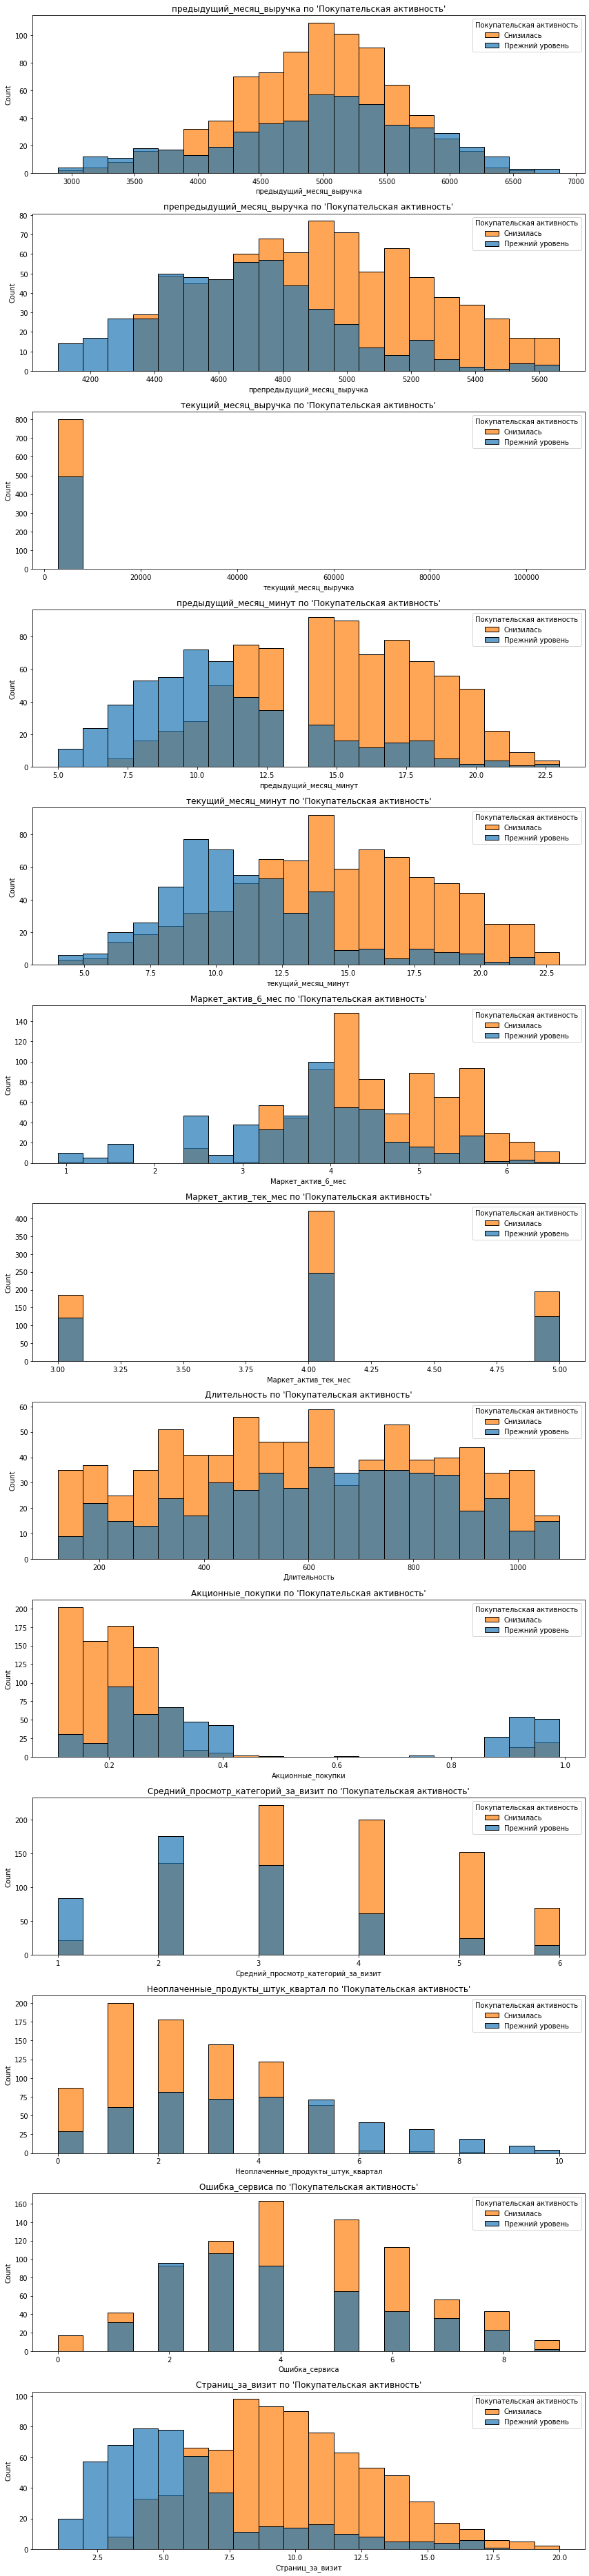

In [13]:
# Создадим отдельную переменную с числовыми столбцами для построения графиков
num_feat = all_numeric_features
# Добавим к датафрейму с числовми столбцами целевой признак
num_feat['Покупательская активность'] = all_features['Покупательская активность']

# Зададим параметры холста для графиков
fig, axes = plt.subplots(nrows=len(all_numeric_features.columns) - 1, ncols=1, figsize=(12, 4 * (len(all_numeric_features.columns) - 1)))


# Передадим значения для легенды
legend_values = num_feat['Покупательская активность'].unique()

# Размещаем графики на сетке
for i, col in enumerate(num_feat.columns[:-1]):
    # Строим гистограмму с разбивкой по 'Покупательская активность'
    sns.histplot(data=num_feat, x=col, hue=num_feat['Покупательская активность'], bins=20, alpha=0.7, ax=axes[i])

    axes[i].set_title(f"{col} по 'Покупательская активность'")
    
    # Add legend with unique values from 'Покупательская активность'
    axes[i].legend(title='Покупательская активность', labels=legend_values)

# Регулируем расстояние между графикамии
plt.tight_layout()

# Показываем графики
plt.show()

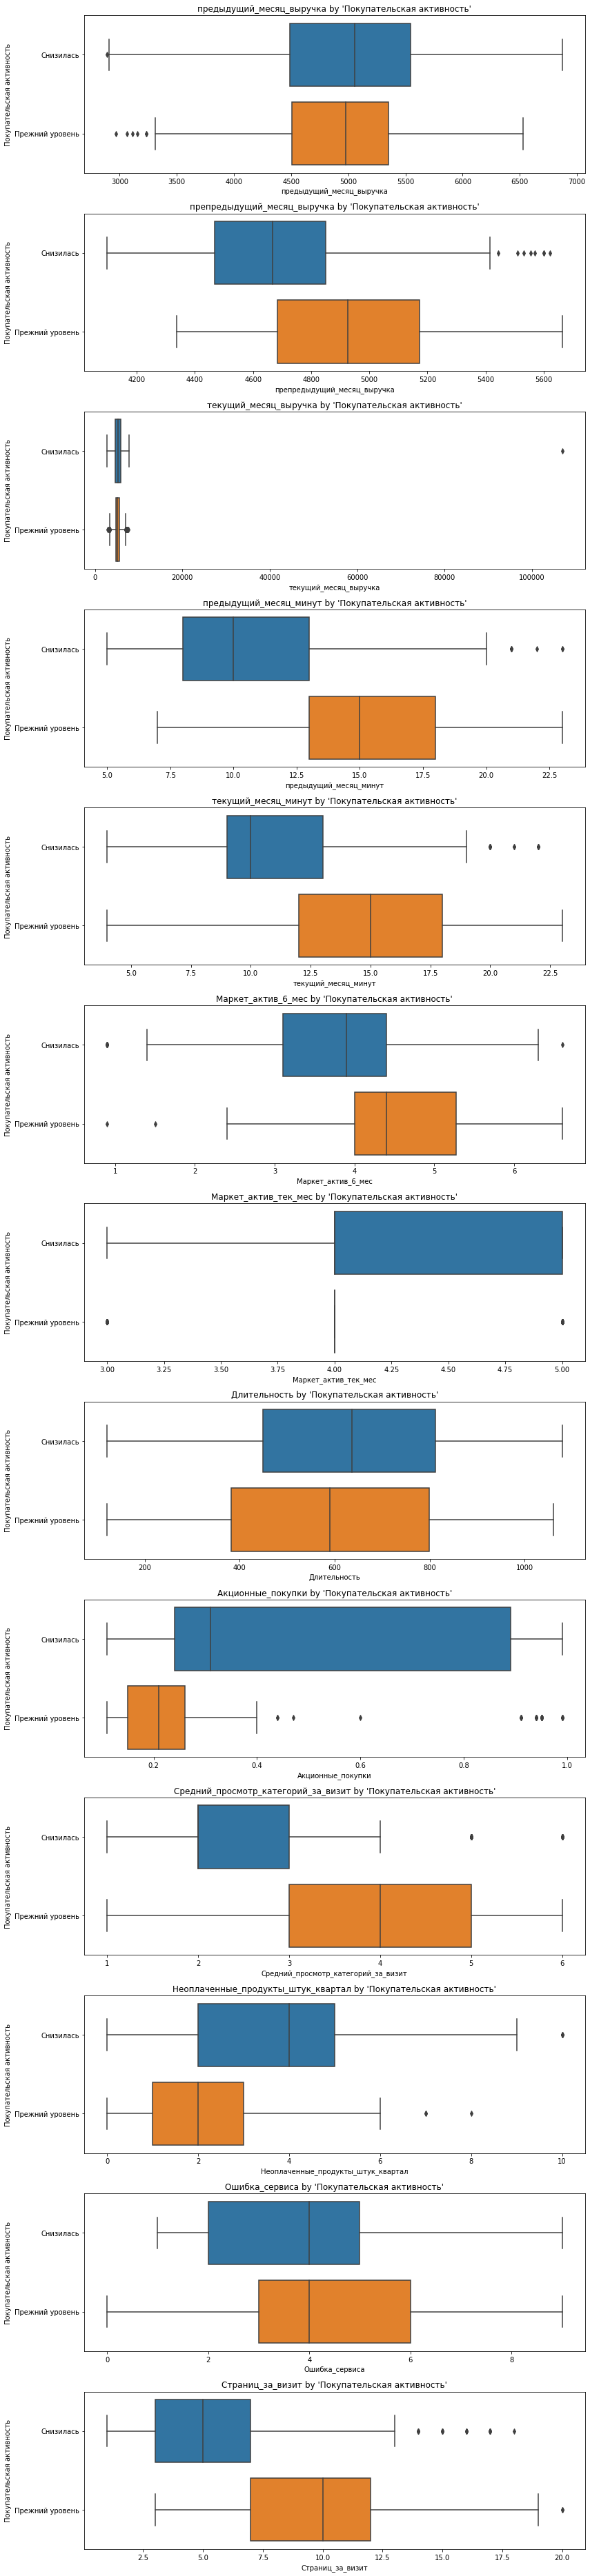

In [14]:
# Зададим параметры холста для графиков
fig, axes = plt.subplots(nrows=len(all_numeric_features.columns) - 1, ncols=1, figsize=(12, 4 * (len(all_numeric_features.columns) - 1)))

# Передадим значения для легенды
legend_values = num_feat['Покупательская активность'].unique()

# Размещаем графики на сетке
for i, col in enumerate(num_feat.columns[:-1]):
    # Строим boxplot с разбивкой по 'Покупательская активность'
    sns.boxplot(x=num_feat[col], y=num_feat['Покупательская активность'], ax=axes[i])

    axes[i].set_title(f"{col} by 'Покупательская активность'")

# Регулируем расстояние между графиками
plt.tight_layout()

# Показываем графики
plt.show()

Боксплот указывает на выбросы почти во всех признаках. Стоит количество неоплаченных продуктов. Среди пользователей чья покупательская активность снизилась медианное значение в два раза вше чем среди тех, чья покупательская способность осталась прежней. Максимальное значение у первых тоже гораздо выше.

Также интересно, что признак медианное значение признака "Ошибка сервиса" для обеих категорий покупателей равно.

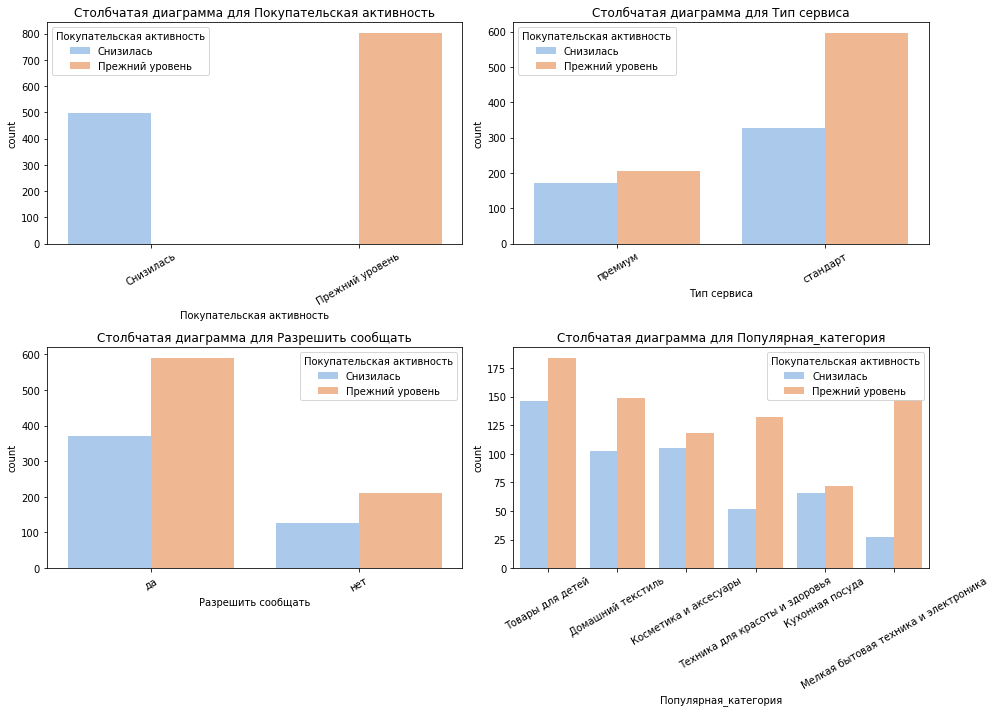

In [15]:
# Создание холста с подграфиками
fig, axes = plt.subplots(nrows=len(all_categorical_features.columns) // 2, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # "Распрямляем" массив подграфиков

# Построение столбчатых диаграмм для каждого категориального признака с разбивкой по бинарному признаку
for i, column in enumerate(all_categorical_features.columns):
    sns.countplot(x=column, hue='Покупательская активность', data=data_market, palette='pastel', ax=axes[i])
    axes[i].set_title(f'Столбчатая диаграмма для {column}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30) 

plt.tight_layout()
plt.show()

Целевой признак распределен неравномерно

### Шаг 4. Объединение таблиц

In [16]:
# Объеденим данные с разбитыми по столбцам периодами 
merged_data = pd.merge(pivot_data_money, data_market,  on='id', how='left')
merged_data = pd.merge(merged_data, pivot_data_time, on='id', how='left')

merged_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   предыдущий_месяц_выручка             1297 non-null   float64
 2   препредыдущий_месяц_выручка          1297 non-null   float64
 3   текущий_месяц_выручка                1297 non-null   float64
 4   Покупательская активность            1297 non-null   object 
 5   Тип сервиса                          1297 non-null   object 
 6   Разрешить сообщать                   1297 non-null   object 
 7   Маркет_актив_6_мес                   1297 non-null   float64
 8   Маркет_актив_тек_мес                 1297 non-null   int64  
 9   Длительность                         1297 non-null   int64  
 10  Акционные_покупки                    1297 non-null   float64
 11  Популярная_категория          

### Шаг 5. Корреляционный анализ

In [17]:
merged_data['текущий_месяц_выручка'].replace(merged_data['текущий_месяц_выручка'].max(), merged_data['текущий_месяц_выручка'].mean(), inplace=True)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:




Тут ты удаляешь выброс, но как ты его нашёл? Для этого и строим график выше

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Перенес графики выше теперь последовательность соблюдена. </div>

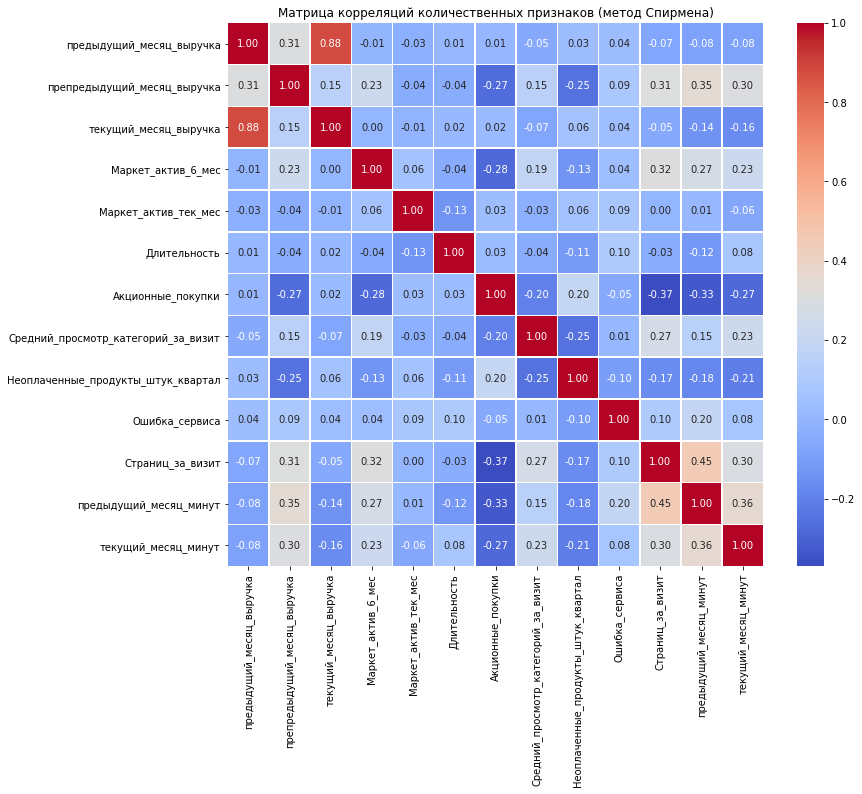

In [18]:
# Создадим список количественных признаков
all_numeric_features = merged_data.select_dtypes(include=['float64', 'int64']).drop('id', axis=1)
# Рассчитаем матрицу корреляций
correlation_matrix = all_numeric_features.corr(method='spearman')


# Визуализируем матрицу корреляций с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций количественных признаков (метод Спирмена)')
plt.show()

Наблюдается мультиколлинеарность между периодами выручки. Важно это учесть при построении моделей LogisticRegression и SVC с ядром leaner, данные модели более чувтствительны к мульиколлинеарности.

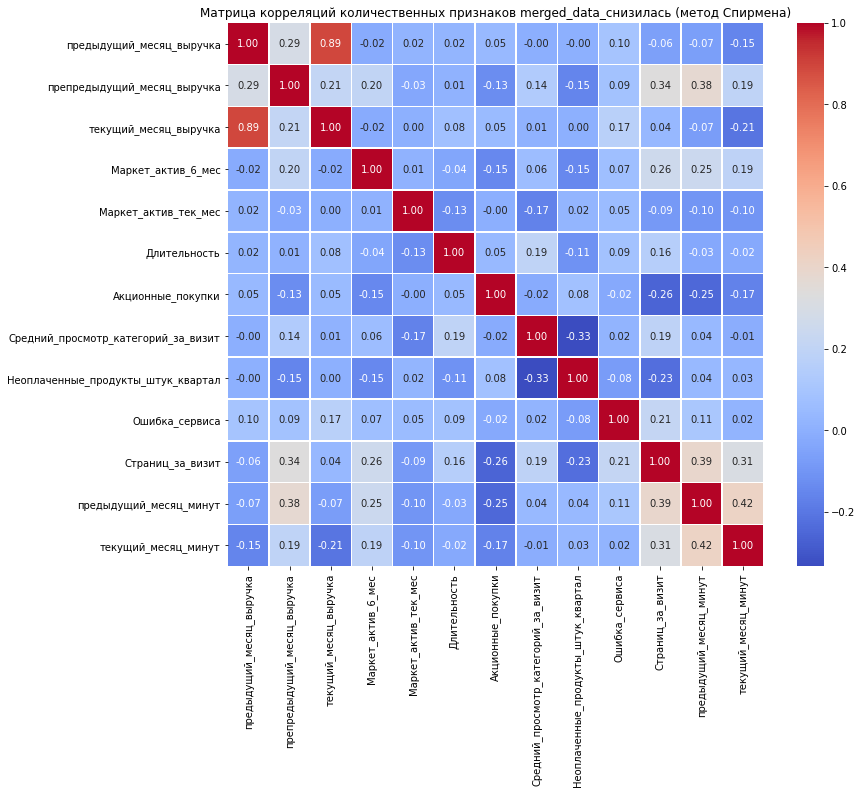

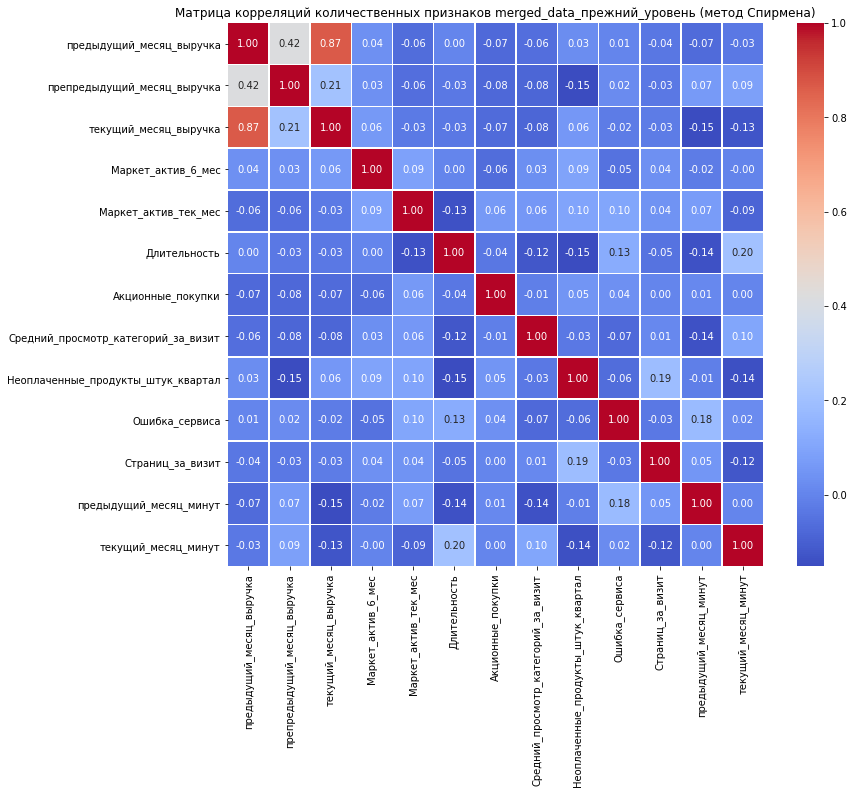

In [19]:
# Разобъем датафрейм по значению таргета
merged_data_снизилась = merged_data[merged_data['Покупательская активность'] == 'Снизилась']
merged_data_прежний_уровень = merged_data[merged_data['Покупательская активность'] == 'Прежний уровень']

# Создадим список количественных признаков для значения таргета
all_numeric_features = merged_data_снизилась.select_dtypes(include=['float64', 'int64']).drop('id', axis=1)
# Рассчитаем матрицу корреляций
correlation_matrix = all_numeric_features.corr(method='spearman')
# Визуализируем матрицу корреляций с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций количественных признаков merged_data_снизилась (метод Спирмена)')
plt.show()


# Создадим список количественных признаков для значения таргета
all_numeric_features = merged_data_прежний_уровень.select_dtypes(include=['float64', 'int64']).drop('id', axis=1)
# Рассчитаем матрицу корреляций
correlation_matrix = all_numeric_features.corr(method='spearman')
# Визуализируем матрицу корреляций с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций количественных признаков merged_data_прежний_уровень (метод Спирмена)')
plt.show()

Матрица корреляций с разбивкой по целевому признаку не выявила новых зависимостией. Но можно отметить, что у пользователей сохранивших прежней уровень покупательской способности зависимость между выручкой за препредыдущий и предыдущий месяц немного выше чем у тех у кого снизилась (0.42 против 0.29). Также стоит отметить, что среди тех у кого покупательская способность осталась прежней корреляция между остальными признаками не превышает 0.3 (по модулю). У тех, у кого способность снизилась корреляция доходит до 0.42.

### Пайплайн

#### Группируем признаки для дальнейшего кодирования и скалирования

In [20]:
# Используем LabelEncoder для целевой, категориальной переменной
LabelEncoder_feature = ['Покупательская активность']

# Скайлеры:
#  StandardScaler используем для количественных переменных, распределение которых близко к нормальному
quantitative_features = ['Маркет_актив_6_мес', 'Длительность', 'Страниц_за_визит', 'предыдущий_месяц_минут', 'текущий_месяц_минут']
# MinMaxScaler используем для дискретных признаков
min_max_scaler_features = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса', 'Неоплаченные_продукты_штук_квартал' ]
# RobustScaler используем для признаков с выбросами
robust_scaler_features = ['Акционные_покупки', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка' , 'текущий_месяц_выручка']

# Кодировщики:
# ohe используем для категориальных признаков
ohe_features = ['Разрешить сообщать', 'Популярная_категория']
# ord используем для признаков, в значениях которых прослеживается порядок
ord_features = ['Тип сервиса']


#### Объеденим обработку данных используя ColumnTransformer

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), quantitative_features),
        ('min_max_scaler', MinMaxScaler(), min_max_scaler_features),
        ('robust_scaler', RobustScaler(), robust_scaler_features),
        ('one_hot_encoder', OneHotEncoder(), ohe_features),
        ('ordinal_encoder', OrdinalEncoder(categories=[['стандарт', 'премиум']]), ord_features)
    ],
 remainder='passthrough')

#### Определим признаки и целевую переменную

In [22]:
# Определите random_state для воспроизводимости
random_state = 42  

# Определяем признаки (X) и целевую переменную (y)
X = merged_data.drop(columns=['Покупательская активность', 'id'])
y = merged_data['Покупательская активность']

# Разделяем данные на обучающий и тестовый наборы с использованием random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Создаем LabelEncoder для кодирования целевой переменной 0 -  «прежний уровень», 1 -  «снизилась» 
label_encoder = LabelEncoder()

# Кодируем целевую переменную в обучающем и тестовом наборе
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

#### Создадим пайплайны для каждой модели

In [23]:
# Создаем пайплайн для каждой модели
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=random_state))
])

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=random_state))
])

svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=random_state))
])

#### Подберем параметры и обучим модель

In [27]:
# Задаем сетку гиперпараметров для каждой модели
knn_param_grid = {'classifier__n_neighbors': [1, 2, 3]}
dt_param_grid = {'classifier__max_depth': [1, 3, 5, 7]}
lr_param_grid = {'classifier__C': [0.1, 2, 3, 5]}
svc_param_grid = {'classifier__C': [0.1, 1, 2, 3, 5, 10], 'classifier__kernel': ['linear']}

# Создаем GridSearchCV для подбора гиперпараметров
knn_grid = GridSearchCV(knn_pipeline, param_grid=knn_param_grid, cv=5, scoring='roc_auc')
dt_grid = GridSearchCV(dt_pipeline, param_grid=dt_param_grid, cv=5, scoring='roc_auc')
lr_grid = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=5, scoring='roc_auc')
svc_grid = GridSearchCV(svc_pipeline, param_grid=svc_param_grid, cv=5, scoring='roc_auc')

# Создаем список моделей для обучения
models = [('KNeighborsClassifier', knn_grid),
          ('DecisionTreeClassifier', dt_grid),
          ('LogisticRegression', lr_grid),
          ('SVC', svc_grid)]

# Обучаем каждую модель
for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"Best parameters: {model.best_params_}")
    print(f"Best {model.scoring} on test set: {model.best_score_}\n")



# Выбор лучшей модели
best_model_name, best_model = max(models, key=lambda x: x[1].best_score_)

Training KNeighborsClassifier...
Best parameters: {'classifier__n_neighbors': 3}
Best roc_auc on test set: 0.8870051460464502

Training DecisionTreeClassifier...
Best parameters: {'classifier__max_depth': 3}
Best roc_auc on test set: 0.8495306827102345

Training LogisticRegression...
Best parameters: {'classifier__C': 5}
Best roc_auc on test set: 0.8978425395262978

Training SVC...
Best parameters: {'classifier__C': 5, 'classifier__kernel': 'linear'}
Best roc_auc on test set: 0.893693707989893



In [28]:
# Находим лучшую модель с лучшими параметрами
best_model_with_params = best_model.best_estimator_

# Обучаем лучшую модель на обучающем наборе данных
best_model_with_params.fit(X_train, y_train)

# Предсказываем вероятности классов для тестового набора
y_probabilities = best_model_with_params.predict_proba(X_test)[:, 1]

# Вычисляем ROC-AUC
roc_auc = roc_auc_score(y_test, y_probabilities)
print(f"Final best model ({best_model_name}) ROC-AUC on test set: {roc_auc}")

Final best model (LogisticRegression) ROC-AUC on test set: 0.9251521425434469


Для оценки качества моделей используем метрику ROC-AUC так как она отражает долю истинных положительных результатов от общего числа истинных положительных случаев и устойчива к несбалансированным классам. 

In [ ]:
train_roc_auc = svc_grid.best_estimator_.score(X_train, y_train)
test_roc_auc = svc_grid.best_estimator_.score(X_test, y_test)
print(lr_grid.best_estimator_)
print(f"ROC AUC on training set: {train_roc_auc}")
print(f"ROC AUC on test set: {test_roc_auc}")

Лучшая модель LogisticRegression, лучший параметр регуляризации - 5.

### Анализ важности признаков

In [ ]:
# Делаем SHAP анализ
best_pipeline = best_model.best_estimator_

X_train_2 = best_pipeline.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(best_pipeline.named_steps['classifier'].predict, X_train_2)

X_test_2 = best_pipeline.named_steps['preprocessor'].transform(X_test)

feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

shap.summary_plot(shap_values, X_test_2)

В данной ситуации explainer указывает на 3 признака с наибольшим влиянием на результат предсказания. Чем больше значение первых 3ех признаков тем больше вероятность, что значение прогноза будет 0. 

Также из графика следует, что увеличение числа акционных покупок сопутствует снижению покупательской активности.

Логическую взаимосвязь можно усмотреть между количеством неоплаченных продуктов в корзине и покупательской активностью. Также видная прямая зависимость между маркетинговоай активностью и покупательской активностью.

In [ ]:
linear_model = best_pipeline.named_steps['classifier']
explainer_linear = shap.LinearExplainer(linear_model, X_train_2)
shap_values_linear = explainer_linear.shap_values(X_test_2)

# Сравниваем SHAP значения для обеих моделей
shap.summary_plot(shap_values_linear, X_test_2, plot_type="bar", feature_names=feature_names)

Класс LinearExplainer выдает похожий топ 3 однако в немного другом порядке. Но максимальная связь попрежнему говорит о том, что если пользователь провел больше времени на сайте вероятность класса 0 будет больше. 

При принятии бизнес решений стоит ориентироваться на минимизацию неолпаченных продуктов в корзине. Т.е. поощрять пользователей завершить покупку.

###  Сегментация покупателей

Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [ ]:
display(merged_data['Неоплаченные_продукты_штук_квартал'].describe(),
merged_data['Акционные_покупки'].describe(), data_monthly_money.describe())

Используем 3ий квартиль для отбора покупателей

In [ ]:
# Объеденим данные о прибыльности с merged_data
all_data = pd.merge(merged_data, data_monthly_money, on='id', how='left')
# Предсказания вероятностей для значения 1 - "снизилась" 
probabilities = best_pipeline.predict_proba(all_data)[:, 1]
# Выбор покупателей с вероятностью принадлежности к классу 1 более чем  0.8
selected_customers = all_data[probabilities > 0.8]
# Отберем максимально рпибыльных клиентов с прибылью от 75 квантиля 4.67
selected_customers = selected_customers[selected_customers['Прибыль'] > 4.67]


display(selected_customers)

Основываясь на важности признаков, чем больше у пользователя неоплаченных товаров в корзине и чем больше доля акционных продуктов в его корзине тем вероятнее его покупательская активность снизится.

In [ ]:
# Посмотрим распределение значения "Прибыль" среди "прибыльных" пользователей, чтобы определить, с каким количеством самых прибыльных клиентов работать
plt.figure(figsize=(10, 6))
plt.hist(selected_customers['Неоплаченные_продукты_штук_квартал'], bins=40, color='skyblue', edgecolor='black')
plt.title('Неоплаченные продукты')
plt.xlabel('Неоплаченные продукты штук квартал')
plt.ylabel('Частота')
plt.show()

In [ ]:
# Посмотрим распределение значения "Акционные_покупки"
plt.figure(figsize=(10, 6))
plt.hist(selected_customers['Акционные_покупки'], bins=40, color='skyblue', edgecolor='black')
plt.title('Акционные покупки')
plt.xlabel('Акционные покупки')
plt.ylabel('Частота')
plt.show()

In [ ]:
sorted_data = merged_data[(merged_data['Неоплаченные_продукты_штук_квартал'] < 4) & (merged_data['Акционные_покупки'] < 0.3)]

display(sorted_data['Покупательская активность'].value_counts())
plt.figure(figsize=(10, 10))
sorted_data['Покупательская активность'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0, 0.1), colors=['skyblue', 'lightcoral'])
plt.title('Распределение Покупательской активности среди пользователей с малым кол-вом неоплаченных продкутов и малой долей акционных покупок')
plt.show()


display(merged_data['Покупательская активность'].value_counts())

plt.figure(figsize=(10, 10))
merged_data['Покупательская активность'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0, 0.1), colors=['skyblue', 'lightcoral'])
plt.title('Распределение покупательской активности среди всех пользователей')
plt.show()

Таким образом пользователям с высокой прибылью, с высокой вероятностью снижения покупательской активности и с большим количеством неоплаченных продуктов в карзине можно сделать специальное предложение. Логичным в данной ситуации будет сделать предложение со скидкой на всю неоплаченную корзину. В таком случае можно ожидать максимального эффекта, так как пользователь уже отобрал желаемые товары соответственно скидка будет максимально таргетирована для пользователя. 

Отберем таких пользователей:

In [ ]:
selected_customers_sorted = selected_customers[(selected_customers['Неоплаченные_продукты_штук_квартал'] > 4) & (selected_customers['Акционные_покупки'] < 0.3)]
display(selected_customers_sorted)

####  Сегментация покупателей: дополнение

In [ ]:
# Создадим противоположную группу (с высокой прибылью но с маленькой вероятностью снижения покупательской активности)
opposite_customers = all_data[probabilities < 0.2]
opposite_customers = opposite_customers[opposite_customers['Прибыль'] > 4.67]

In [ ]:
# Количество пользователей в основной выборке
len(selected_customers)

In [ ]:
# Выберем такое же количество пользователей в противоположную выборку для сравнимости и наглядности
opposite_customers = opposite_customers.sort_values(by='Прибыль', ascending=False).head(76)

In [ ]:
# Создадим дополнительный столбец с "маркером" в каждой выборке для дальнейшего объединения
opposite_customers['group'] = 'opposite'
selected_customers['group'] = 'selected'

In [ ]:
# Объеденим в один датафрейм для дальнейшего построения графиков
segments = pd.concat([opposite_customers, selected_customers], ignore_index=True)

In [ ]:
# Отберем столбцы для построения графиков
segments_num = segments.select_dtypes(include=['float64', 'int64']).drop('id', axis=1)
segments_num['group'] = segments['group']
segments_cat = segments.select_dtypes(include=['object']).drop('Покупательская активность', axis=1)

In [ ]:


# Зададим параметры холста для графиков
fig, axes = plt.subplots(nrows=len(segments_num.columns) - 1, ncols=1, figsize=(12, 4 * (len(segments_num.columns) - 1)))

# Передадим значения для легенды
legend_values = segments_num['group'].unique()

# Размещаем графики на сетке
for i, col in enumerate(segments_num.columns[:-1]):
    # Строим гистограмму с разбивкой по 'group'
    sns.histplot(data=segments_num, x=col, hue=segments_num['group'], bins=20, alpha=0.7, ax=axes[i])

    axes[i].set_title(f"{col} по 'group'")
    
    # Добавим легенду 'group'
    axes[i].legend(title='group', labels=legend_values)


plt.tight_layout()

# Показываем графики
plt.show()




# Зададим параметры холста для графиков
fig, axes = plt.subplots(nrows=len(segments_num.columns) - 1, ncols=1, figsize=(12, 4 * (len(segments_num.columns) - 1)))

# Передадим значения для легенды
legend_values = segments_num['group'].unique()

# Размещаем графики на сетке
for i, col in enumerate(segments_num.columns[:-1]):
    # Строим boxplot с разбивкой по 'group'
    sns.boxplot(x=segments_num[col], y=segments_num['group'], ax=axes[i])

    axes[i].set_title(f"{col} by 'group'")


plt.tight_layout()

# Показываем графики
plt.show()



# Создание холста с подграфиками
fig, axes = plt.subplots(nrows=len(segments_cat.columns) // 2, ncols=2, figsize=(14, 8))
axes = axes.flatten() 

# Построение столбчатых диаграмм для каждого категориального признака с разбивкой по бинарному признаку 'group'
for i, column in enumerate(segments_cat.columns):
    sns.countplot(x=column, hue='group', data=segments_cat, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Столбчатая диаграмма для {column}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=70, ha='right')

plt.tight_layout()
plt.show()




Признак средний просмотр категорий за визит у пользователей с большой прибылью и прежним уровнем покупательской активностью в 2 раза выше чем у пользователей с высокой прибылью но снижающейся активностью. Т.е. можно поработать над тем, чтобы на сайте пользователю предлагались товары, которые могут ему понравится на основании тех, с которыми он взаимодействовал ранее. Для усиления эффекта на эти товары можно также предлагать скидку.

Еще можно отметить, что за последние 6 месяцев у пользователей чья активность осталась прежней, маркетинговая активность была выше. Т.е. ее нужно держать на высоком уровне.
В текущем месяце маркетинговая активность выше у тех, чья покупатльская активность снизилась. Вероятно это можно объяснить тем, что менеджмент пытается спасти ситуацию.

Задача - Предотвращение снижения покупательской активности:

- Разработка модели МЛ для предсказания пользователей со склонностью к снижению покупательской активности.
- Разработка предложения для предотвращения снижения покупательской активности.

Данные - Исходные данные содержат информацию о поведении покупателей на сайте, выручке от покупателей, времени, проведенном пользователем на сайте и о среднемесячной прибыли. Предобработка данных потребовала изменения типов данных и унификации категориальных признаков. Также потребовалось исключить неактивных клиентов из анализа.

Модель - Для поиска лучшей модели потребовалось задействовать пайплайн, в который мы передали несколько моделей, несколько обработчиков данных и несколько параметров для каждой модели. Gridsearch перебрал все комбинации и выявил лучшую модель на основании характеристики roc-auc, которая стала наиболее подходящей по причине наличия выбросов в данных.

Лучшая модель:
Training LogisticRegression...
Best parameters: {'classifier__C': 5}
Best roc_auc on the test set: 0.9251521425434469

Выводы: Исходя из важности признаков модели и выбранного сегмента следует, что необходимо сохранять высокую маркетинговую активность, предлогать пользователям товары со скидкой на основании их предыдущих взаимодействий а также предлогать скидку на неоплаченную корзину для мотивации завершить покупку.